<a href="https://colab.research.google.com/github/ykbintang/Growco-Corn_Plant_Disease_Detection_System/blob/main/notebook/Corn_disease_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Understanding

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import zipfile
import os
import matplotlib.image as mpimg
import keras_preprocessing
from keras_preprocessing import image
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(
      name=fn))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json"


In [3]:
!chmod 600 /content/kaggle.json

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [5]:
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

100% 160M/161M [00:07<00:00, 25.9MB/s]
100% 161M/161M [00:07<00:00, 21.7MB/s]


In [6]:
# melakukan ekstraksi pada file zip
import zipfile
local_zip = 'corn-or-maize-leaf-disease-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/corn-or-maize-leaf-disease-dataset/')
zip_ref.close()

In [7]:
# Mendefinisikan direktori utama dataset
base_dir = '/content/corn-or-maize-leaf-disease-dataset/data'

In [8]:
print(os.listdir(base_dir))

['Healthy', 'Common_Rust', 'Gray_Leaf_Spot', 'Blight']


In [9]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 4188


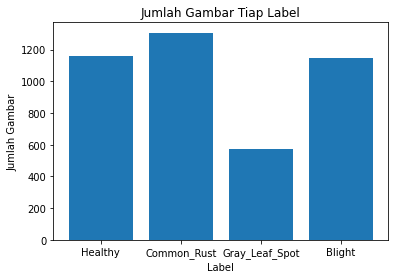

In [10]:
# Visualisasi jumlah gambar tiap kelas
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

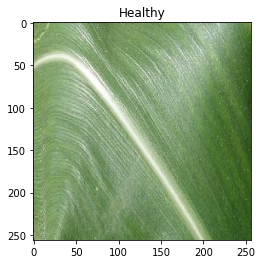

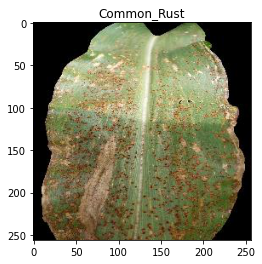

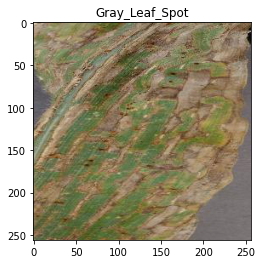

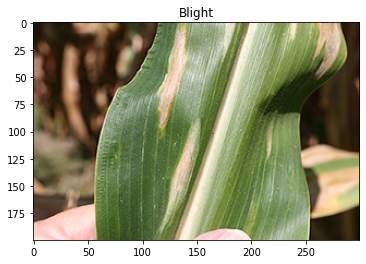

In [11]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

## Data Preprocessing

In [12]:
IMAGE_SIZE = (200,200)
BATCH_SIZE = 32
SEED = 999

In [13]:
# Menggunakan ImageDataGenerator untuk preprocessing
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [14]:
# Menyiapkan data train dan data validation
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


In [15]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

## Model Development

In [16]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(224,224,3), strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(4, activation='softmax')
])

In [17]:
# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [18]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)       

In [19]:
# Menambahkan callbacks early stoppping
from tensorflow.keras.callbacks import EarlyStopping

callbacks = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=4
)

## Training Model

In [22]:
# Training model CNN
cnn_hist = cnn_model.fit(
    train_data,
    epochs=30,
    validation_data = valid_data,
    verbose=2,
    callbacks=[callbacks]
    )

Epoch 1/30
105/105 - 17s - loss: 0.1670 - accuracy: 0.9382 - val_loss: 0.2666 - val_accuracy: 0.8983 - 17s/epoch - 159ms/step
Epoch 2/30
105/105 - 17s - loss: 0.1643 - accuracy: 0.9344 - val_loss: 0.2296 - val_accuracy: 0.9151 - 17s/epoch - 159ms/step
Epoch 3/30
105/105 - 17s - loss: 0.1730 - accuracy: 0.9347 - val_loss: 0.1839 - val_accuracy: 0.9294 - 17s/epoch - 160ms/step
Epoch 4/30
105/105 - 17s - loss: 0.1655 - accuracy: 0.9376 - val_loss: 0.3930 - val_accuracy: 0.8373 - 17s/epoch - 160ms/step
Epoch 5/30
105/105 - 17s - loss: 0.2018 - accuracy: 0.9269 - val_loss: 0.2570 - val_accuracy: 0.9115 - 17s/epoch - 159ms/step
Epoch 6/30
105/105 - 17s - loss: 0.1725 - accuracy: 0.9344 - val_loss: 0.2469 - val_accuracy: 0.9091 - 17s/epoch - 159ms/step
Epoch 7/30
105/105 - 17s - loss: 0.1487 - accuracy: 0.9445 - val_loss: 0.2496 - val_accuracy: 0.9211 - 17s/epoch - 159ms/step
Epoch 7: early stopping


## Visualization

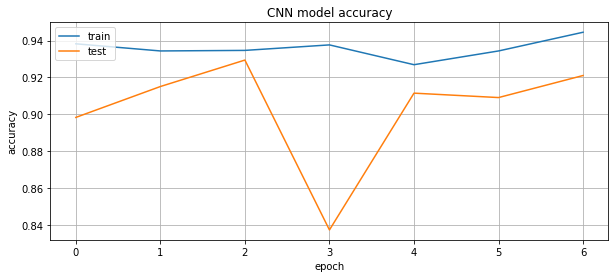

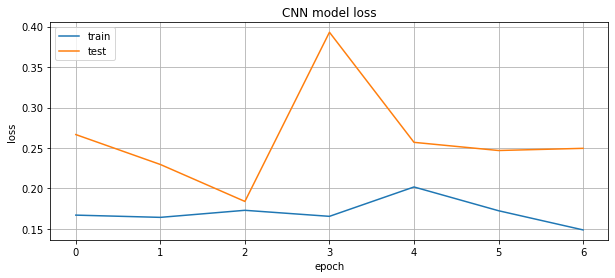

In [23]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Prediction

In [24]:
y_pred = cnn_model.predict(valid_data)

27/27 [==============================] - 3s 112ms/step


In [25]:
y_pred

array([[7.4246091e-01, 1.7779991e-04, 2.5736099e-01, 2.3494636e-07],
       [8.9827853e-01, 2.2333579e-03, 9.9427186e-02, 6.1034047e-05],
       [2.5013848e-03, 4.8078181e-08, 9.9749857e-01, 1.8216744e-15],
       ...,
       [9.1101960e-05, 5.0549777e-05, 5.8200112e-06, 9.9985254e-01],
       [7.5670582e-04, 6.1030715e-04, 8.5160616e-05, 9.9854785e-01],
       [1.1996618e-18, 1.0000000e+00, 1.0705997e-21, 2.5800711e-26]],
      dtype=float32)

In [26]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 2, 3, 1, 0, 3, 2, 3, 0, 0, 0, 1, 3, 2, 1, 1, 0, 3, 1, 3, 2,
       1, 1, 1, 3, 0, 3, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 2, 3, 2, 1, 1, 3,
       3, 1, 3, 1, 1, 1, 2, 0, 3, 3, 0, 3, 1, 2, 2, 3, 1, 1, 0, 3, 3, 0,
       3, 1, 3, 1, 2, 1, 0, 3, 1, 1, 0, 0, 3, 3, 2, 1, 2, 3, 1, 0, 0, 3,
       0, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 1, 0, 3, 0, 0, 2, 2, 1, 0, 3, 3,
       0, 2, 3, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 3, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 3, 1, 0, 2, 1, 3, 2, 3, 1, 1, 1, 0, 3, 1, 3, 0, 3, 2, 1, 0, 0,
       0, 0, 3, 0, 3, 3, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       2, 3, 1, 3, 2, 3, 1, 2, 1, 0, 1, 2, 0, 0, 2, 3, 0, 3, 2, 1, 1, 0,
       3, 1, 0, 3, 1, 1, 3, 1, 0, 2, 1, 1, 3, 0, 0, 1, 0, 3, 3, 1, 2, 3,
       2, 1, 0, 2, 3, 1, 1, 1, 3, 2, 0, 1, 1, 2, 2, 3, 0, 2, 2, 3, 1, 3,
       3, 1, 2, 1, 1, 1, 2, 3, 3, 3, 3, 0, 1, 3, 2, 0, 0, 2, 1, 0, 2, 3,
       1, 3, 2, 3, 0, 2, 0, 1, 0, 3, 3, 0, 1, 1, 1, 2, 2, 3, 3, 0, 3, 1,
       1, 0, 1, 3, 3, 1, 1, 2, 1, 0, 0, 1, 0, 2, 3,

In [27]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}

## Testing Model

Saving Corn_Gray_Spot.jpeg to Corn_Gray_Spot.jpeg
1/1 [==============================] - 0s 178ms/step
Tanamanmu terkena penyakit Gray Leaf Spot!


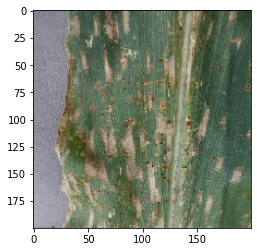

In [28]:
# Menguji model
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)

  # Preprocessing image
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = cnn_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes, axis=1)
  
  # print(fn)
  if classes==0: #Blight
    pred="Tanamanmu terkena penyakit Blight!" 
  elif classes==1: #Common_Rust
    pred="Tanamanmu terkena penyakit Common Rust!"
  elif classes==2: #Gray_Leaf_Spot
    pred="Tanamanmu terkena penyakit Gray Leaf Spot!"
  else: #Healthy
    pred="Yeay, tanamanmu sehat :)"

  print(pred)

## Save Model

In [29]:
cnn_model.save_weights('corn_disease_models_weight.h5')

In [30]:
# save ke json
model_json = cnn_model.to_json()
with open('corn_disease_models_1.json', 'w') as json_file:
  json_file.write(model_json)

In [31]:
# save ke h5 file
from tensorflow.keras.models import load_model

cnn_model.save('corn_disease_models.h5')